In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


1) **Imports & Config**

In [ ]:
import numpy as np                        # Numerical arrays and math
import pandas as pd                       # DataFrame manipulation and CSV loading
import matplotlib.pyplot as plt           # Plotting library used by LIME for figures
from sklearn.model_selection import train_test_split  # Train/test splitting utility
from sklearn.preprocessing import StandardScaler      # Feature scaling for models that need it
from sklearn.pipeline import Pipeline                 # Compose preprocessing + model in one object
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression   # Logistic Regression classifier
from sklearn.svm import SVC                           # Support Vector Machine classifier
from sklearn.neural_network import MLPClassifier       # Multi-Layer Perceptron classifier
from sklearn.inspection import permutation_importance  # Global importance via permutation
from lime.lime_tabular import LimeTabularExplainer      # LIME for tabular data
import warnings
warnings.filterwarnings("ignore")


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



**2) Load your uploaded diabetes.csv file**

In [ ]:
CSV_PATH = "/content/drive/MyDrive/csc790Fall2025/diabetes.csv"

EXPECTED_COLS = [
"Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
"Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]

# Load
try:
  df = pd.read_csv(CSV_PATH)    # Load the CSV into a DataFrame
except FileNotFoundError:
# Fallback to current directory; useful if you run locally
  CSV_PATH = "/content/drive/MyDrive/csc790Fall2025/diabetes.csv"
  df = pd.read_csv(CSV_PATH)


# Validate columns and target
missing = [c for c in EXPECTED_COLS if c not in df.columns]
if missing:
  raise ValueError(f"CSV missing expected columns: {missing}. Found: {df.columns.tolist()}")


TARGET_COL = "Outcome"
FEATURES = [c for c in df.columns if c != TARGET_COL]


# Preview
print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist()) # Print the actual columns detected
print(df.head(3))

Loaded dataframe shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  


3) Train/Test split & arrays

In [ ]:
X = df[FEATURES] # Feature matrix as DataFrame
y = df[TARGET_COL].astype(int) # Target vector as integers (0/1)


# Create a stratified split so class proportions are maintained in train/test.
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)


# Convert to NumPy arrays for LIME (it expects raw numpy arrays for training_data).
X_train_np = X_train.values # Training features as ndarray
X_test_np = X_test.values # Test features as ndarray
feature_names = FEATURES # Keep a Python list of feature names for LIME
class_names = ["No", "Yes"] # Human-readable class names for LIME legends


d = X_train_np.shape[1] # Number of features (d) used in formulas
print(f"Train: {X_train_np.shape}, Test: {X_test_np.shape}, d={d}") # Shape summary

Train: (537, 8), Test: (231, 8), d=8


4) Define models & evaluation

In [ ]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()), # Standardize each feature to mean 0, std 1
    ("clf", LogisticRegression(max_iter=200, # Logistic regression (linear model)
                              solver="lbfgs", # LBFGS optimizer is robust for small datasets
                              random_state=RANDOM_STATE)),# Seed for reproducibility
])


pipe_svm = Pipeline([
        ("scaler", StandardScaler()), # Scale features for SVM
        ("clf", SVC(kernel="rbf", # Non-linear RBF kernel SVM
                      probability=True, # Enable predict_proba() required by LIME/metrics
                      C=1.0, # Regularization strength (default reasonable value)
                      gamma="scale", # Gamma heuristic based on feature variance
                      random_state=RANDOM_STATE)), # Seed affects internal shuffling/SMO init
])


pipe_mlp = Pipeline([
      ("scaler", StandardScaler()), # Scale features for neural net stability
      ("clf", MLPClassifier(hidden_layer_sizes=(64, 32), # Two hidden layers: 64 then 32 neurons
                            activation="relu", # ReLU nonlinearity
                            solver="adam", # Adam optimizer (works well out of the box)
                            alpha=1e-3, # L2 regularization to prevent overfitting
                            max_iter=400, # Training epochs upper bound
                            random_state=RANDOM_STATE)), # Seed for weight initialization
])


# Group models in a dict to loop over them conveniently.
models = {
        "LogisticRegression": pipe_lr, # Linear baseline
        "SVM(RBF)": pipe_svm, # Non-linear kernel method
        "MLP": pipe_mlp, # Feedforward neural network
}


# Define a helper to fit a model and compute core metrics used in classification reports.
def evaluate(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr) # Train the pipeline on training data
    proba = model.predict_proba(Xte)[:, 1] # Predicted probability for positive class
    pred = (proba >= 0.5).astype(int) # Convert probabilities to hard labels using 0.5 threshold
    return { # Return a dictionary of metric values
          "ACC": accuracy_score(yte, pred), # Overall accuracy
          "PREC": precision_score(yte, pred, zero_division=0), # Positive predictive value
          "REC": recall_score(yte, pred, zero_division=0), # True positive rate
          "F1": f1_score(yte, pred, zero_division=0), # Harmonic mean of precision and recall
          "ROC_AUC": roc_auc_score(yte, proba), # Threshold-independent discrimination metric
          }


# Run evaluation for each model and collect into a DataFrame for easy viewing.
results = {name: evaluate(m, X_train, y_train, X_test, y_test) for name, m in models.items()}
metrics_df = pd.DataFrame(results).T.round(3) # Make a table with rounded values
print("Model metrics (higher ROC_AUC is better):") # Header for readability
print(metrics_df.sort_values("ROC_AUC", ascending=False)) # Show models sorted by ROC_AUC

Model metrics (higher ROC_AUC is better):
                      ACC   PREC    REC     F1  ROC_AUC
LogisticRegression  0.745  0.677  0.519  0.587    0.838
SVM(RBF)            0.749  0.677  0.543  0.603    0.811
MLP                 0.727  0.625  0.556  0.588    0.784


5) LIME explainer & 5 explanations


Chosen test indices: [np.int64(135), np.int64(16), np.int64(154), np.int64(200), np.int64(20)]


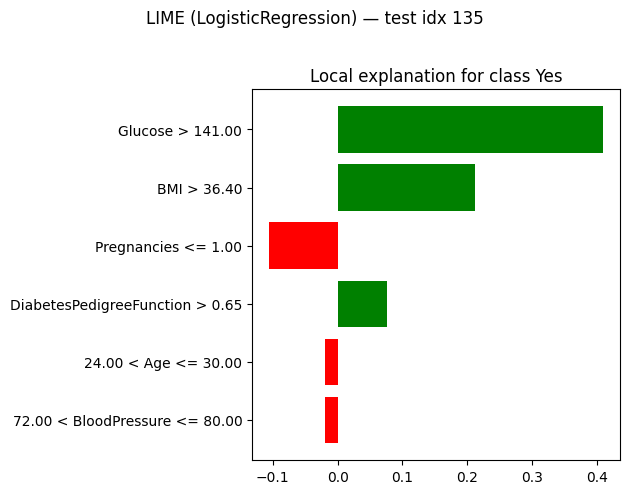

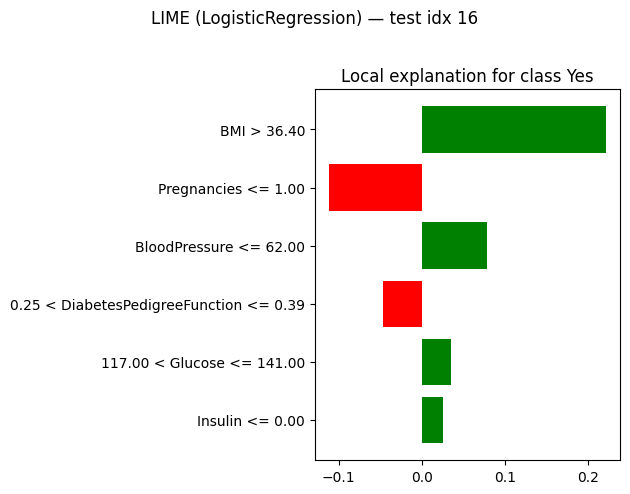

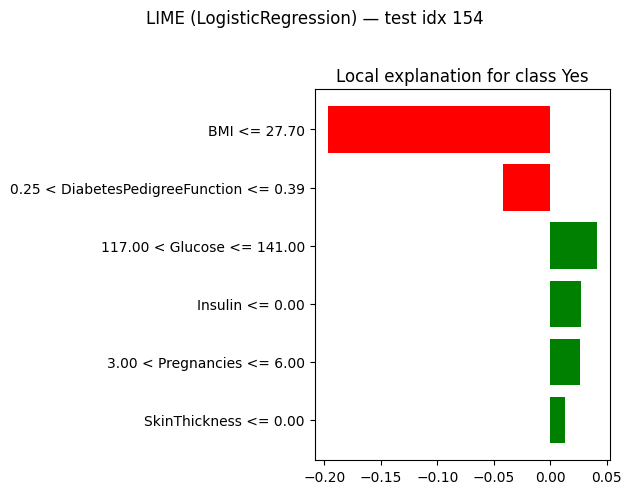

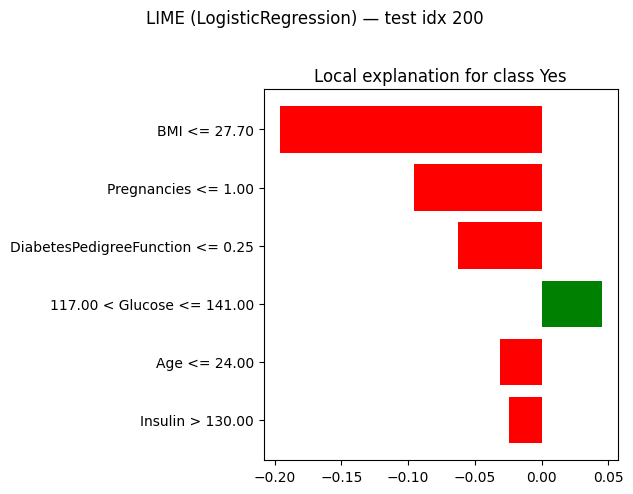

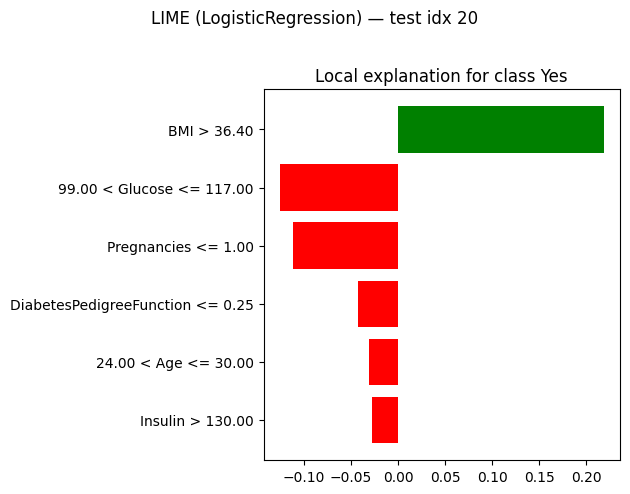


Top local features for LogisticRegression:


,sample_idx,f1,f2,f3,f4,f5,f6
0,135,Glucose > 141.00 (+0.410),BMI > 36.40 (+0.213),Pregnancies <= 1.00 (-0.106),DiabetesPedigreeFunction > 0.65 (+0.077),24.00 < Age <= 30.00 (-0.020),72.00 < BloodPressure <= 80.00 (-0.019)
1,16,BMI > 36.40 (+0.221),Pregnancies <= 1.00 (-0.112),BloodPressure <= 62.00 (+0.078),0.25 < DiabetesPedigreeFunction <= 0.39 (-0.047),117.00 < Glucose <= 141.00 (+0.035),Insulin <= 0.00 (+0.025)
2,154,BMI <= 27.70 (-0.197),0.25 < DiabetesPedigreeFunction <= 0.39 (-0.042),117.00 < Glucose <= 141.00 (+0.041),Insulin <= 0.00 (+0.027),3.00 < Pregnancies <= 6.00 (+0.027),SkinThickness <= 0.00 (+0.013)
3,200,BMI <= 27.70 (-0.196),Pregnancies <= 1.00 (-0.096),DiabetesPedigreeFunction <= 0.25 (-0.063),117.00 < Glucose <= 141.00 (+0.045),Age <= 24.00 (-0.031),Insulin > 130.00 (-0.024)
4,20,BMI > 36.40 (+0.219),99.00 < Glucose <= 117.00 (-0.126),Pregnancies <= 1.00 (-0.112),DiabetesPedigreeFunction <= 0.25 (-0.043),24.00 < Age <= 30.00 (-0.031),Insulin > 130.00 (-0.028)


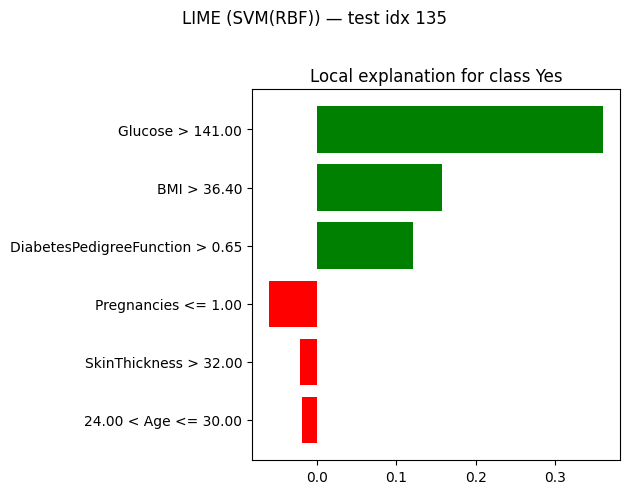

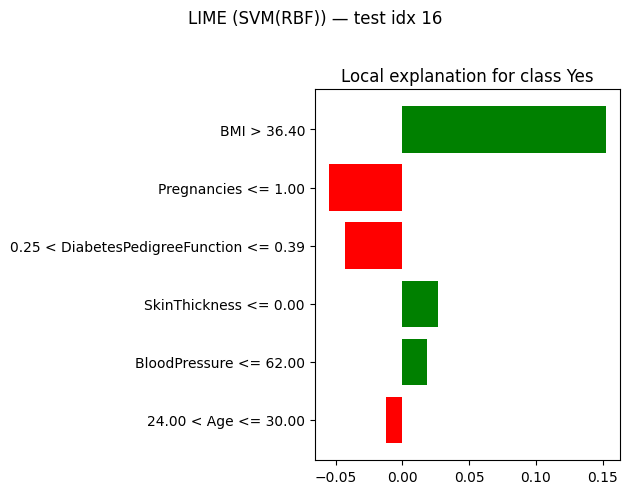

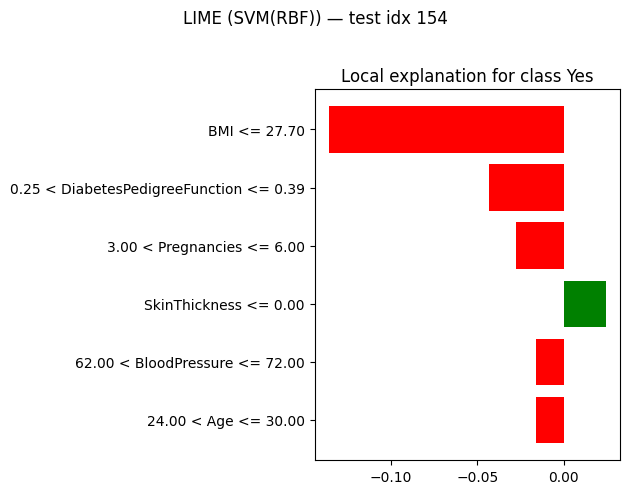

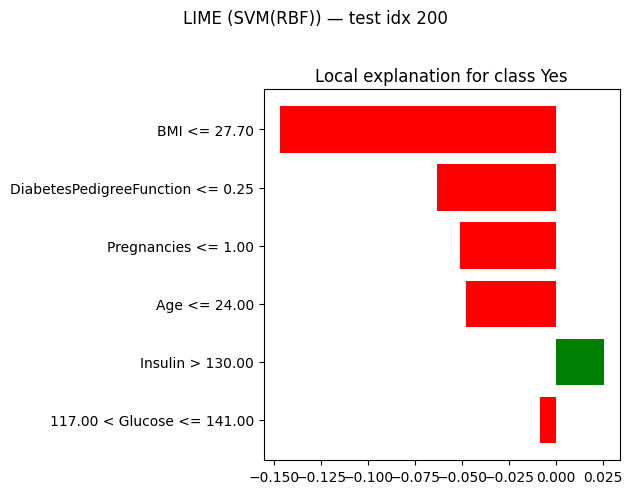

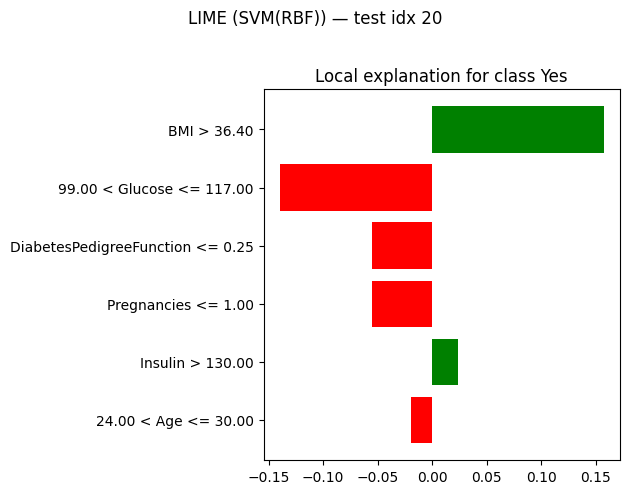


Top local features for SVM(RBF):


,sample_idx,f1,f2,f3,f4,f5,f6
0,135,Glucose > 141.00 (+0.361),BMI > 36.40 (+0.158),DiabetesPedigreeFunction > 0.65 (+0.121),Pregnancies <= 1.00 (-0.060),SkinThickness > 32.00 (-0.020),24.00 < Age <= 30.00 (-0.018)
1,16,BMI > 36.40 (+0.153),Pregnancies <= 1.00 (-0.055),0.25 < DiabetesPedigreeFunction <= 0.39 (-0.043),SkinThickness <= 0.00 (+0.026),BloodPressure <= 62.00 (+0.018),24.00 < Age <= 30.00 (-0.012)
2,154,BMI <= 27.70 (-0.136),0.25 < DiabetesPedigreeFunction <= 0.39 (-0.043),3.00 < Pregnancies <= 6.00 (-0.028),SkinThickness <= 0.00 (+0.025),62.00 < BloodPressure <= 72.00 (-0.016),24.00 < Age <= 30.00 (-0.016)
3,200,BMI <= 27.70 (-0.147),DiabetesPedigreeFunction <= 0.25 (-0.063),Pregnancies <= 1.00 (-0.051),Age <= 24.00 (-0.048),Insulin > 130.00 (+0.025),117.00 < Glucose <= 141.00 (-0.008)
4,20,BMI > 36.40 (+0.158),99.00 < Glucose <= 117.00 (-0.140),DiabetesPedigreeFunction <= 0.25 (-0.056),Pregnancies <= 1.00 (-0.055),Insulin > 130.00 (+0.024),24.00 < Age <= 30.00 (-0.020)


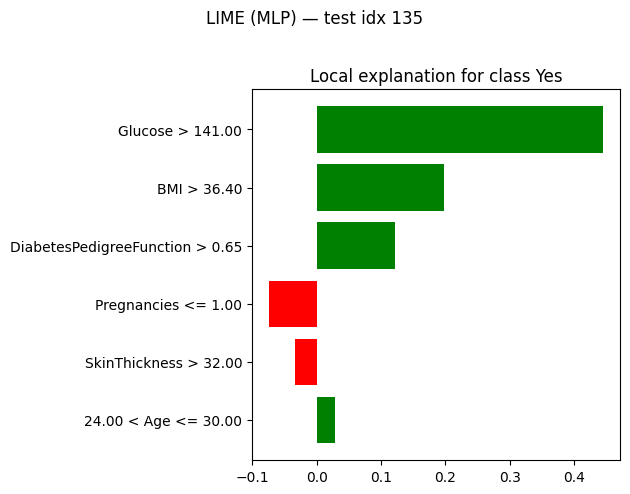

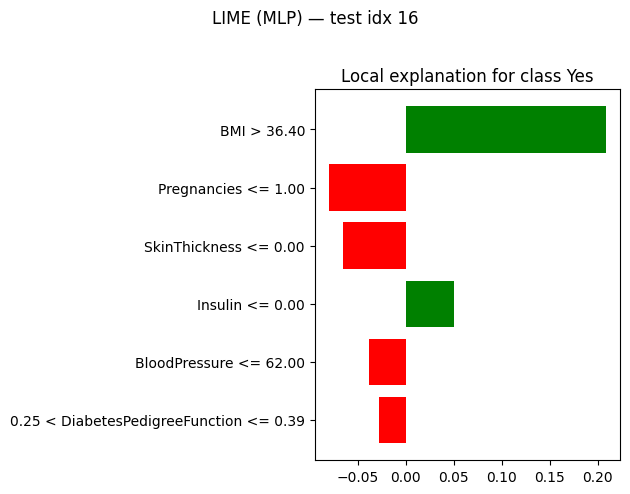

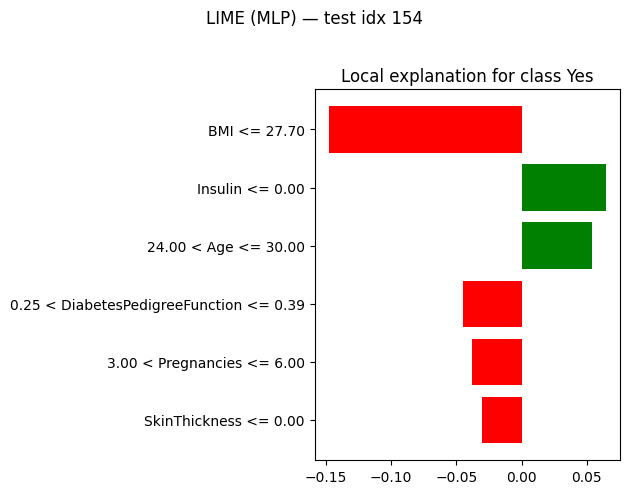

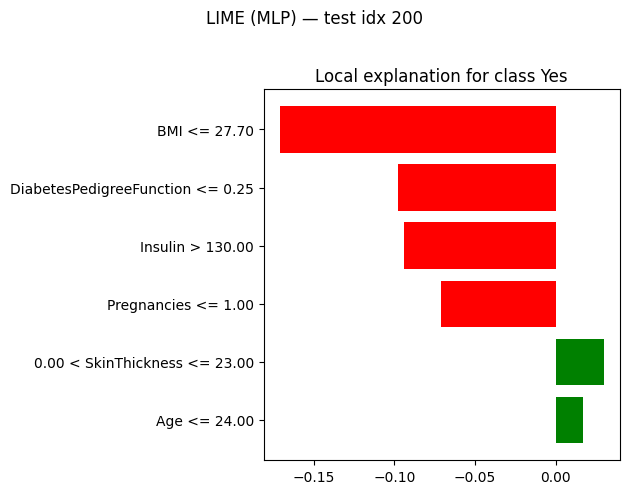

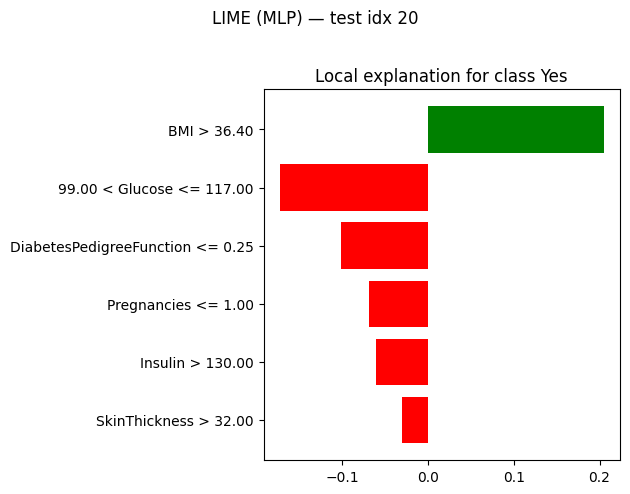


Top local features for MLP:


,sample_idx,f1,f2,f3,f4,f5,f6
0,135,Glucose > 141.00 (+0.445),BMI > 36.40 (+0.198),DiabetesPedigreeFunction > 0.65 (+0.122),Pregnancies <= 1.00 (-0.075),SkinThickness > 32.00 (-0.034),24.00 < Age <= 30.00 (+0.028)
1,16,BMI > 36.40 (+0.209),Pregnancies <= 1.00 (-0.080),SkinThickness <= 0.00 (-0.066),Insulin <= 0.00 (+0.050),BloodPressure <= 62.00 (-0.039),0.25 < DiabetesPedigreeFunction <= 0.39 (-0.028)
2,154,BMI <= 27.70 (-0.148),Insulin <= 0.00 (+0.065),24.00 < Age <= 30.00 (+0.054),0.25 < DiabetesPedigreeFunction <= 0.39 (-0.045),3.00 < Pregnancies <= 6.00 (-0.038),SkinThickness <= 0.00 (-0.030)
3,200,BMI <= 27.70 (-0.171),DiabetesPedigreeFunction <= 0.25 (-0.098),Insulin > 130.00 (-0.094),Pregnancies <= 1.00 (-0.071),0.00 < SkinThickness <= 23.00 (+0.030),Age <= 24.00 (+0.017)
4,20,BMI > 36.40 (+0.205),99.00 < Glucose <= 117.00 (-0.172),DiabetesPedigreeFunction <= 0.25 (-0.101),Pregnancies <= 1.00 (-0.069),Insulin > 130.00 (-0.060),SkinThickness > 32.00 (-0.030)


In [ ]:
def proba_fn(pipeline):
    return lambda X: pipeline.predict_proba(X) # Return a function that outputs class probabilities


DEFAULT_KW = 0.75 * np.sqrt(d) # Default kernel width specified by the assignment


# Construct one explainer with the default kernel width.
explainer = LimeTabularExplainer(
          training_data=X_train_np, # Raw training data array
          feature_names=feature_names, # List of column names for labeling
          class_names=class_names, # Names of classes [0-label, 1-label]
          discretize_continuous=True, # Discretize continuous vars for linear surrogate stability
          kernel_width=DEFAULT_KW, # Locality scale parameter (0.75√d by default)
          random_state=RANDOM_STATE, # Seed so we can reproduce explanations
          )


# Select 5 test indices (3 positives + 2 negatives if available)
pos_idx = np.where(y_test.values == 1)[0] # Indices of positives in test set
neg_idx = np.where(y_test.values == 0)[0] # Indices of negatives in test set
rng = np.random.default_rng(RANDOM_STATE) # Random generator for sampling indices
chosen = list(rng.choice(pos_idx, size=min(3, len(pos_idx)), replace=False)) + \
list(rng.choice(neg_idx, size=min(2, len(neg_idx)), replace=False)) # Combine selections
chosen = chosen[:5]
print("\nChosen test indices:", chosen)

# Function to generate and display LIME explanations for multiple indices
def explain_samples(model_name, pipeline, indices, top_features=6):
    rows = [] # Collect summary rows for a table
    for i in indices: # Iterate over selected test indices
        x = X_test_np[i] # Extract the single instance as ndarray
        exp = explainer.explain_instance( # Ask LIME to explain this instance
              data_row=x, # The instance to explain (raw feature vector)
              predict_fn=proba_fn(pipeline), # Function that returns predict_proba for the model
              num_features=top_features, # How many local features to display
        )
        feat_weights = dict(exp.as_list(label=1)) # Get feature→weight list for class 1 and convert to dict
        sorted_feats = sorted( # Sort features by absolute contribution magnitude
                        feat_weights.items(), key=lambda kv: -abs(kv[1])
                        )[:top_features] # Keep only the top-k entries
        rows.append({ # Add a row summarizing the explanation
        "sample_idx": int(i), # Which test index we explained
        **{f"f{j+1}": f"{name} ({w:+.3f})" for j, (name, w) in enumerate(sorted_feats)},
        })
        fig = exp.as_pyplot_figure(label=1) # Produce the standard LIME bar plot for class 1
        fig.suptitle(f"LIME ({model_name}) — test idx {i}", y=1.02) # Add a title for clarity
        plt.tight_layout() # Reduce overlap between labels and title
        plt.show() # Display the plot in the notebook
    return pd.DataFrame(rows) # Return a compact table of top local features


# Build per-model tables of explanations for the chosen indices and display them.

lime_tables = {}                        # Dict to store tables by model name
for name, model in models.items():      # Loop through each trained model pipeline
    lime_tables[name] = explain_samples(name, model, chosen, top_features=6)
    print(f"\nTop local features for {name}:")
    display(lime_tables[name])

6) Global indicators for feature alignment

In [ ]:
# Fit LR to get coefficients (after scaling in pipeline)
_ = models["LogisticRegression"].fit(X_train, y_train)
coef_lr = models["LogisticRegression"]["clf"].coef_.ravel()
coef_series = pd.Series(coef_lr, index=feature_names).sort_values(key=np.abs, ascending=False)
print("\nLogistic Regression coefficients (sorted by |coef|):\n")
print(coef_series.head(10))


# Permutation importance for SVM and MLP (uses ROC_AUC)
for name in ["SVM(RBF)", "MLP"]:
    model = models[name]
    r = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, scoring="roc_auc")
    imp = pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)
    print(f"\nPermutation importance — {name} (top 10):\n")
    print(imp.head(10))



Logistic Regression coefficients (sorted by |coef|):

Glucose                     1.122905
BMI                         0.711123
Pregnancies                 0.456320
DiabetesPedigreeFunction    0.234348
BloodPressure              -0.201972
Age                         0.096158
Insulin                    -0.075888
SkinThickness              -0.039277
dtype: float64

Permutation importance — SVM(RBF) (top 10):

Glucose                     0.123984
BMI                         0.027704
Age                         0.017333
DiabetesPedigreeFunction    0.015210
Pregnancies                 0.012757
Insulin                     0.001383
SkinThickness              -0.005844
BloodPressure              -0.008313
dtype: float64

Permutation importance — MLP (top 10):

Glucose                     0.141481
Age                         0.045037
Pregnancies                 0.038453
BMI                         0.030881
Insulin                     0.016016
DiabetesPedigreeFunction    0.012560
BloodPressure 

7) Kernel width sensitivity on two test samples


=== Logistic Regression: kernel width sensitivity ===

Test idx 135 | kernel_width = 0.25·√d (kw=0.7071)
 Glucose > 141.00                              +0.3618
 BMI > 36.40                                   +0.1908
 Pregnancies <= 1.00                           -0.0820
 DiabetesPedigreeFunction > 0.65               +0.0805
 0.00 < Insulin <= 38.00                       +0.0776
 72.00 < BloodPressure <= 80.00                -0.0097


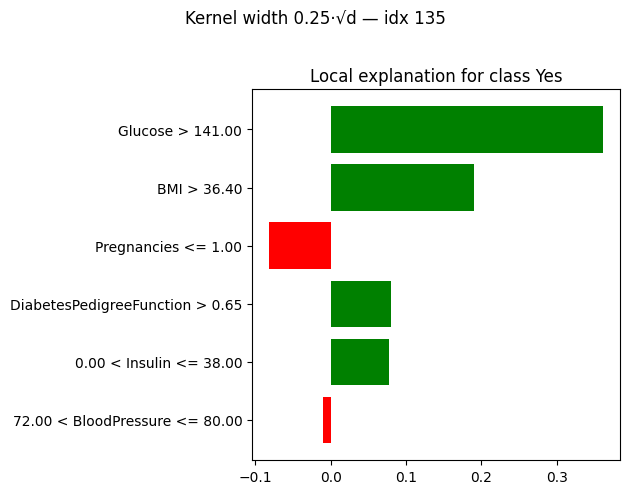


Test idx 135 | kernel_width = 0.75·√d (kw=2.1213)
 Glucose > 141.00                              +0.4096
 BMI > 36.40                                   +0.2126
 Pregnancies <= 1.00                           -0.1060
 DiabetesPedigreeFunction > 0.65               +0.0767
 24.00 < Age <= 30.00                          -0.0197
 72.00 < BloodPressure <= 80.00                -0.0192


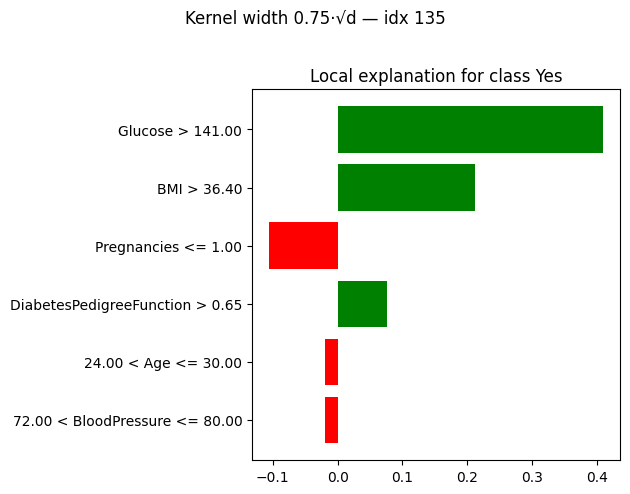


Test idx 135 | kernel_width = 1.0·√d (kw=2.8284)
 Glucose > 141.00                              +0.4096
 BMI > 36.40                                   +0.2129
 Pregnancies <= 1.00                           -0.1056
 DiabetesPedigreeFunction > 0.65               +0.0766
 24.00 < Age <= 30.00                          -0.0197
 72.00 < BloodPressure <= 80.00                -0.0190


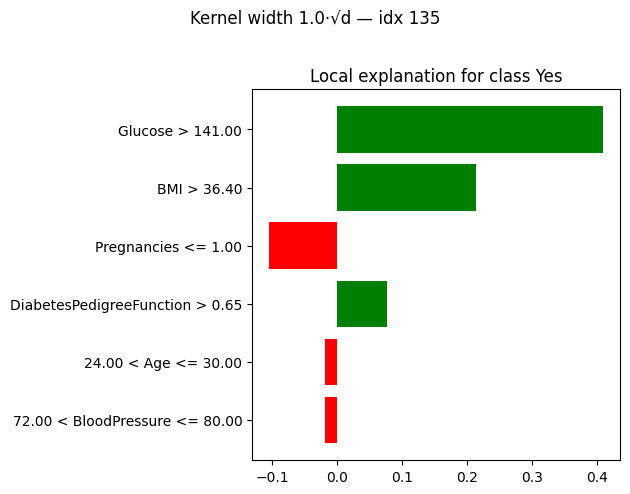


=== MLP: kernel width sensitivity ===

Test idx 16 | kernel_width = 0.25·√d (kw=0.7071)
 BMI > 36.40                                   +0.1934
 117.00 < Glucose <= 141.00                    +0.1058
 Insulin <= 0.00                               +0.0589
 24.00 < Age <= 30.00                          +0.0395
 Pregnancies <= 1.00                           -0.0291
 BloodPressure <= 62.00                        +0.0286


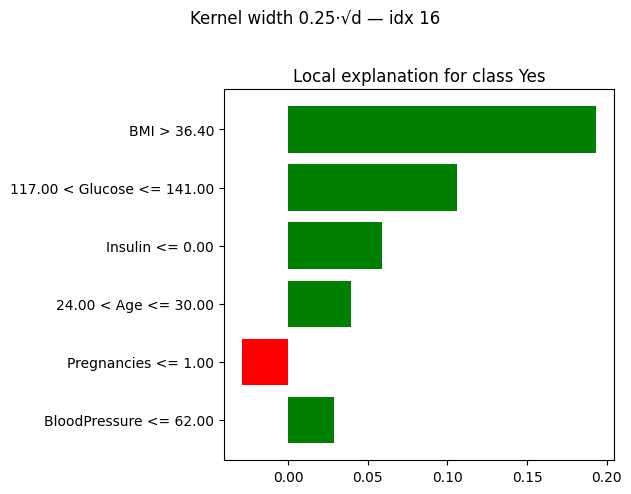


Test idx 16 | kernel_width = 0.75·√d (kw=2.1213)
 BMI > 36.40                                   +0.1976
 Pregnancies <= 1.00                           -0.0714
 SkinThickness <= 0.00                         -0.0435
 Insulin <= 0.00                               +0.0397
 117.00 < Glucose <= 141.00                    +0.0385
 0.25 < DiabetesPedigreeFunction <= 0.39       -0.0334


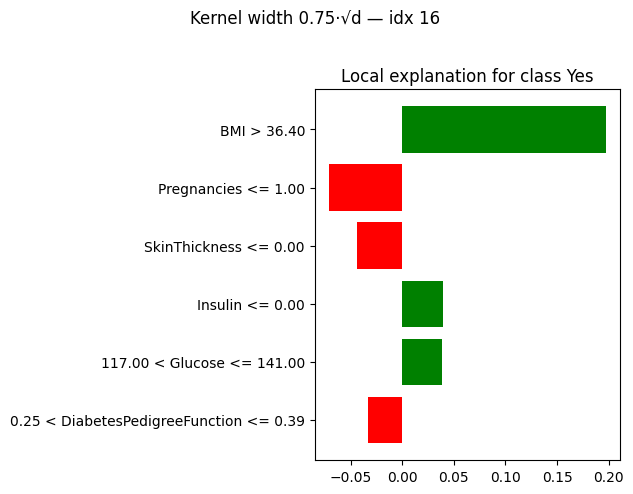


Test idx 16 | kernel_width = 1.0·√d (kw=2.8284)
 BMI > 36.40                                   +0.1980
 Pregnancies <= 1.00                           -0.0724
 SkinThickness <= 0.00                         -0.0443
 Insulin <= 0.00                               +0.0394
 117.00 < Glucose <= 141.00                    +0.0361
 0.25 < DiabetesPedigreeFunction <= 0.39       -0.0346


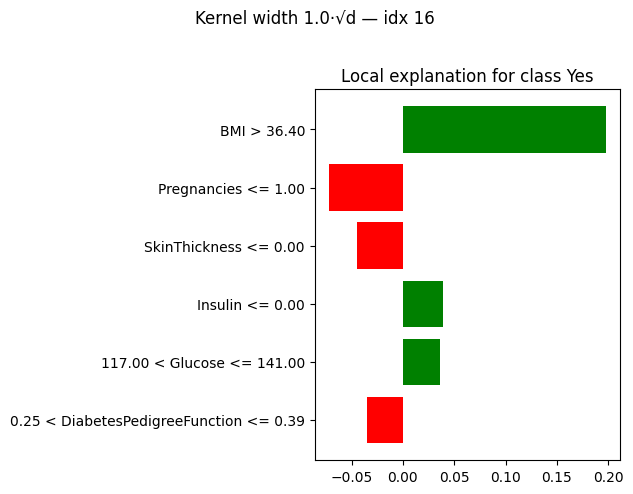

In [ ]:
width_factors = [0.25, 0.75, 1.0] # Factors to multiply √d for kernel_width
selected_for_kw = chosen[:2] if len(chosen) >= 2 else chosen # Pick two samples from our previously chosen list


# Helper to run LIME with different kernel widths for a single instance and model.
def kernel_width_experiment(pipeline, sample_index, k=6):
    x = X_test_np[sample_index] # Extract the target instance by index
    for wf in width_factors: # Iterate over each kernel width factor
        kw = wf * np.sqrt(d) # Convert factor to absolute kernel width
        # Build a fresh explainer for THIS kernel width
        local_explainer = LimeTabularExplainer(
            training_data=X_train_np,
            feature_names=feature_names,
            class_names=class_names,
            discretize_continuous=True,
            kernel_width=kw,
            random_state=RANDOM_STATE,
            )


        # >>> IMPORTANT: all lines below must remain INSIDE the for-loop <<<
        # Explain the same instance using the current width
        exp = local_explainer.explain_instance(
            data_row=x,
            predict_fn=proba_fn(pipeline),
            num_features=k,
        )


        # Print the width factor and the resulting feature contributions
        print(f"\nTest idx {sample_index} | kernel_width = {wf}·√d (kw={kw:.4f})")
        for feat, w in exp.as_list(label=1):
            print(f" {feat:45s} {w:+.4f}")


        # Plot the bar chart for this width
        fig = exp.as_pyplot_figure(label=1)
        fig.suptitle(f"Kernel width {wf}·√d — idx {sample_index}", y=1.02)
        plt.tight_layout()
        plt.show()


print("\n=== Logistic Regression: kernel width sensitivity ===")
kernel_width_experiment(models["LogisticRegression"], selected_for_kw[0])


print("\n=== MLP: kernel width sensitivity ===")
kernel_width_experiment(models["MLP"], selected_for_kw[-1])

8) Final metrics table for the report

In [ ]:
print("\nFinal metrics table:\n")
print(metrics_df.sort_values("ROC_AUC", ascending=False))


Final metrics table:

                      ACC   PREC    REC     F1  ROC_AUC
LogisticRegression  0.745  0.677  0.519  0.587    0.838
SVM(RBF)            0.749  0.677  0.543  0.603    0.811
MLP                 0.727  0.625  0.556  0.588    0.784
